### Базовые подходы работы с временными рядами

In [21]:
res_name = "restaurant_01"

In [22]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')
import Handlers as hd

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (10, 8)
sns.set_palette('flare')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
df = pd.read_csv(f"../data/{res_name}_ts.csv", index_col=0, parse_dates=[0])
df.index.freq = "D"
df

,Orders
2019-06-10,1.0
2019-06-11,14.0
2019-06-12,332.0
2019-06-13,770.0
2019-06-14,840.0
...,...
2023-07-27,2060.0
2023-07-28,2051.0
2023-07-29,1488.0
2023-07-30,2196.0


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1513 entries, 2019-06-10 to 2023-07-31
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Orders  1497 non-null   float64
dtypes: float64(1)
memory usage: 23.6 KB


### Заполняю пропуски линейной интерполяцией

In [203]:
df["Orders"].interpolate(method="linear", inplace=True)
# преобразую количество заказов к целому типу
df["Orders"] = df["Orders"].astype(int)

In [204]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1513 entries, 2019-06-10 to 2023-07-31
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Orders  1513 non-null   int32
dtypes: int32(1)
memory usage: 17.7 KB


### Trend

В виде скользящего срденего

In [205]:
df['trend_1Y'] = df['Orders'].rolling(365).mean()
df

,Orders,trend_1Y
2019-06-10,1,NaN
2019-06-11,14,NaN
2019-06-12,332,NaN
2019-06-13,770,NaN
2019-06-14,840,NaN
...,...,...
2023-07-27,2060,1376.246575
2023-07-28,2051,1377.057534
2023-07-29,1488,1375.608219
2023-07-30,2196,1376.200000


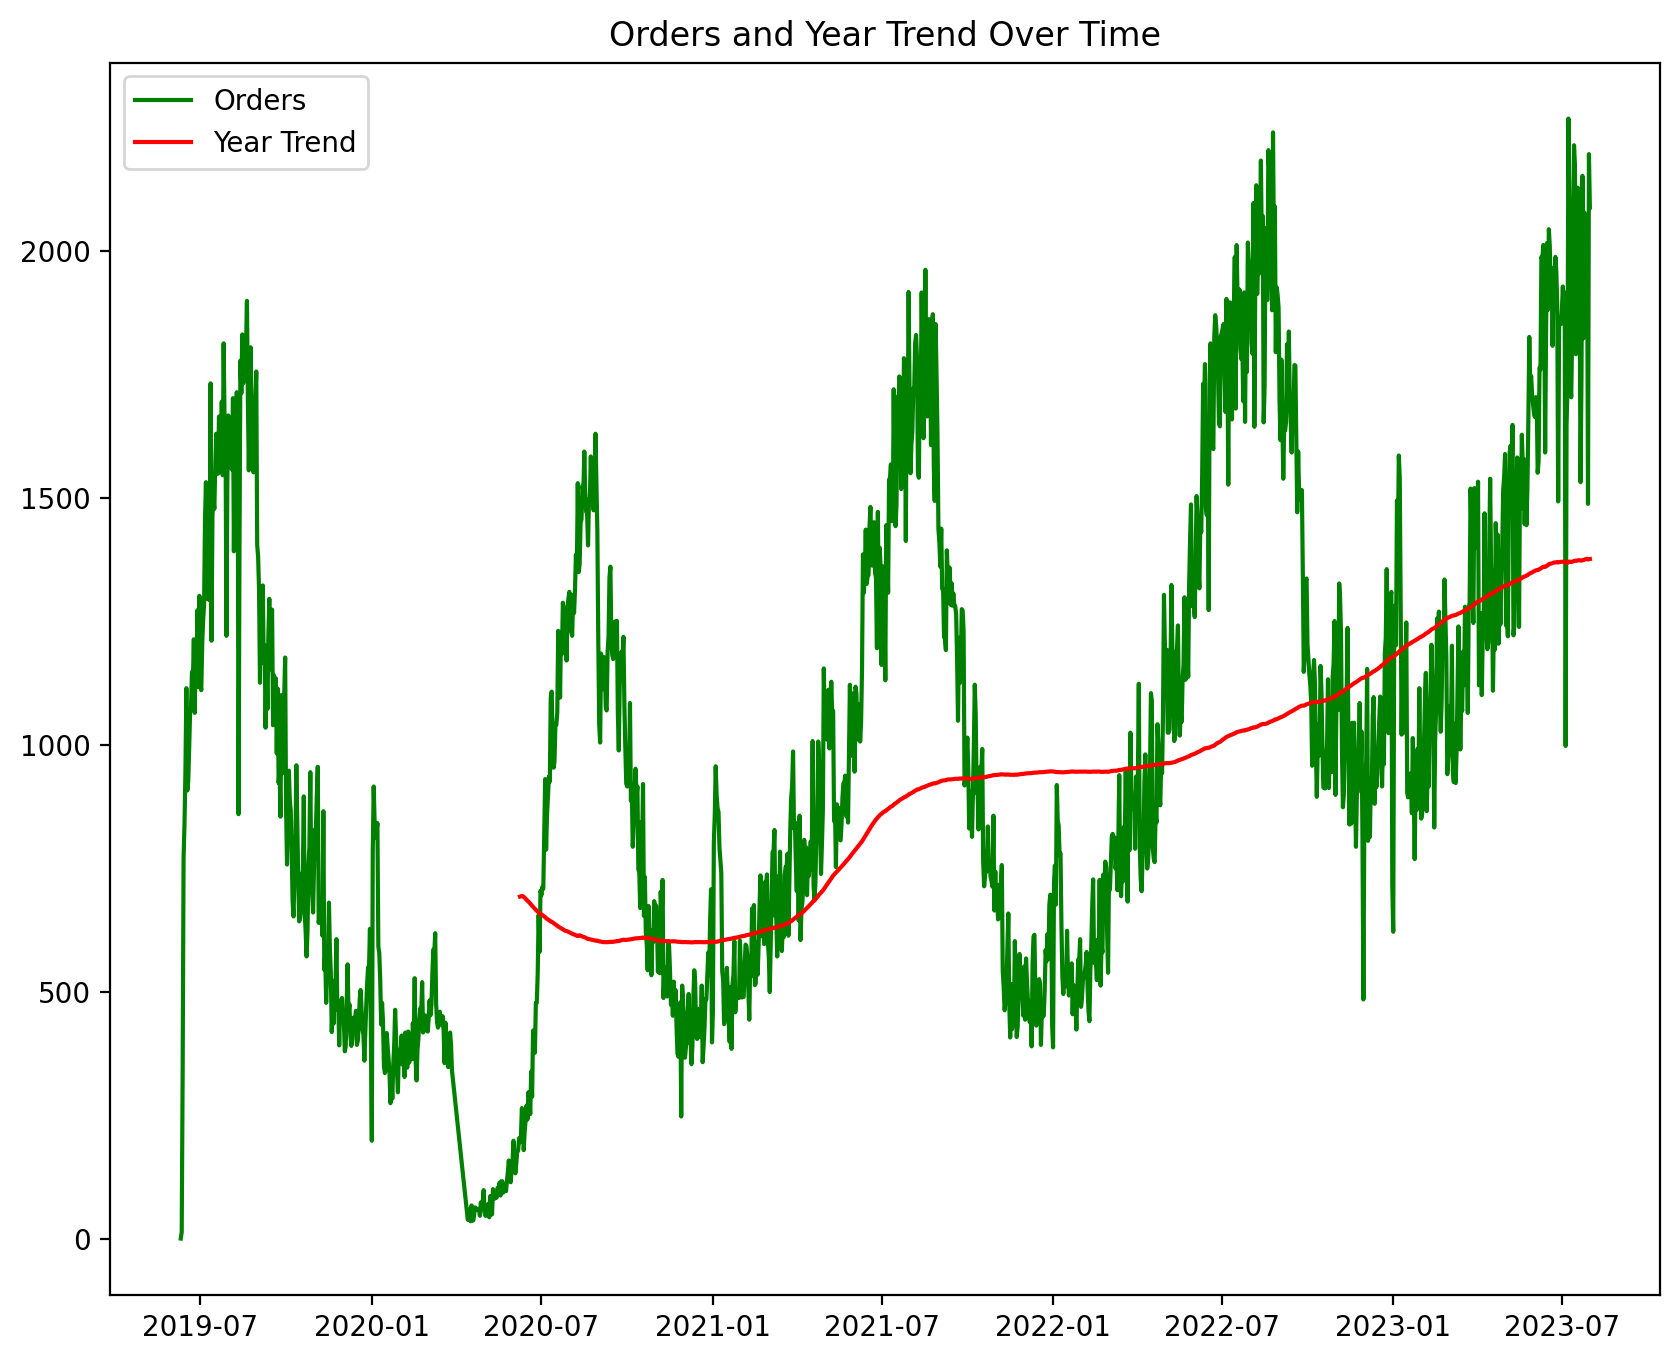

In [206]:
plt.plot(df.index, df['Orders'], label='Orders', color='green')
plt.plot(df.index, df['trend_1Y'], label='Year Trend', color='red')
plt.legend()
plt.title('Orders and Year Trend Over Time')
plt.show()

# Использование Линейной регрессии

In [207]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=df.index,  # dates from the training data
    constant=False,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()
X

,trend
2019-06-10,1.0
2019-06-11,2.0
2019-06-12,3.0
2019-06-13,4.0
2019-06-14,5.0
...,...
2023-07-27,1509.0
2023-07-28,1510.0
2023-07-29,1511.0
2023-07-30,1512.0


Создание модели LR

In [208]:
from sklearn.linear_model import LinearRegression

y = df["Orders"]

# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_pred

2019-06-10     600.451275
2019-06-11     600.969880
2019-06-12     601.488484
2019-06-13     602.007088
2019-06-14     602.525693
                 ...     
2023-07-27    1382.506693
2023-07-28    1383.025298
2023-07-29    1383.543902
2023-07-30    1384.062506
2023-07-31    1384.581111
Freq: D, Length: 1513, dtype: float64

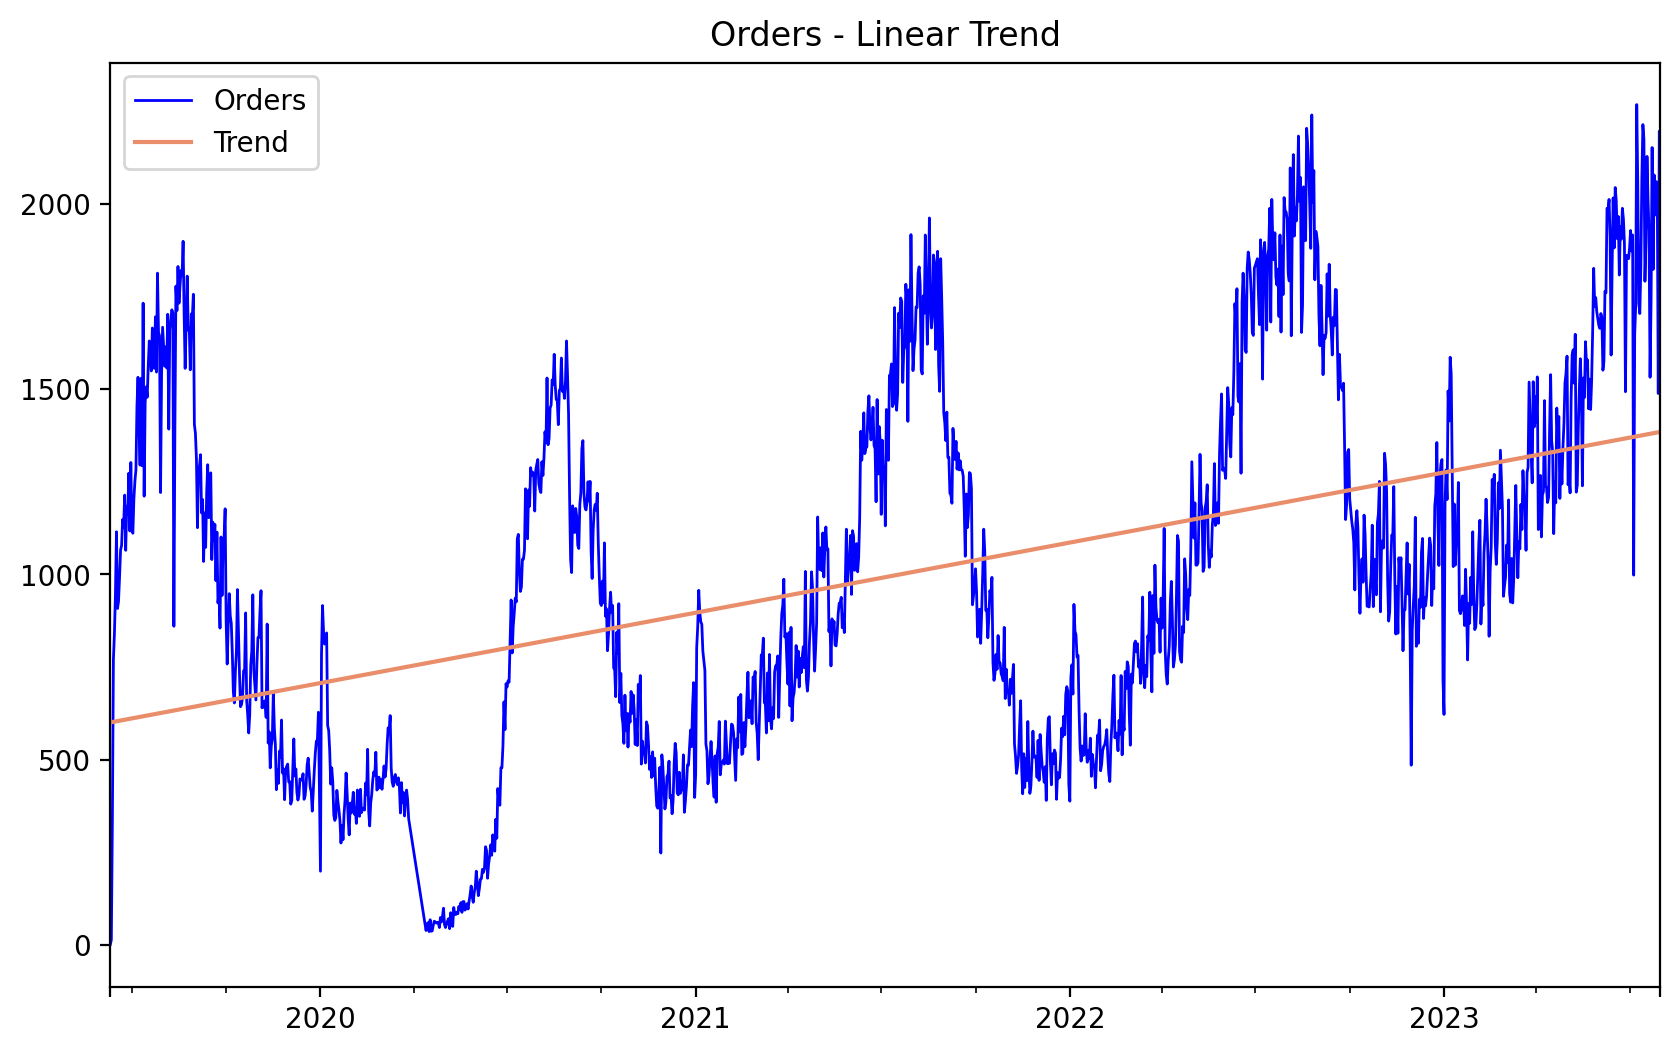

In [209]:
ax = df.plot(y="Orders", figsize=(10, 6), linewidth=1, color="blue", title="Orders - Linear Trend")
y_pred.plot(y="Orders", markersize=2, ax=ax, label='Trend')
ax.legend()
plt.show()

To make a forecast, we apply our model to "out of sample" features. "Out of sample" refers to times outside of the observation period of the training data. Here's how we could make a 30-day forecast:

In [210]:
X = dp.out_of_sample(steps=180)
y_fore = pd.Series(model.predict(X), index=X.index)
y_fore

2023-08-01    1385.099715
2023-08-02    1385.618320
2023-08-03    1386.136924
2023-08-04    1386.655528
2023-08-05    1387.174133
                 ...     
2024-01-23    1475.855483
2024-01-24    1476.374088
2024-01-25    1476.892692
2024-01-26    1477.411296
2024-01-27    1477.929901
Freq: D, Length: 180, dtype: float64

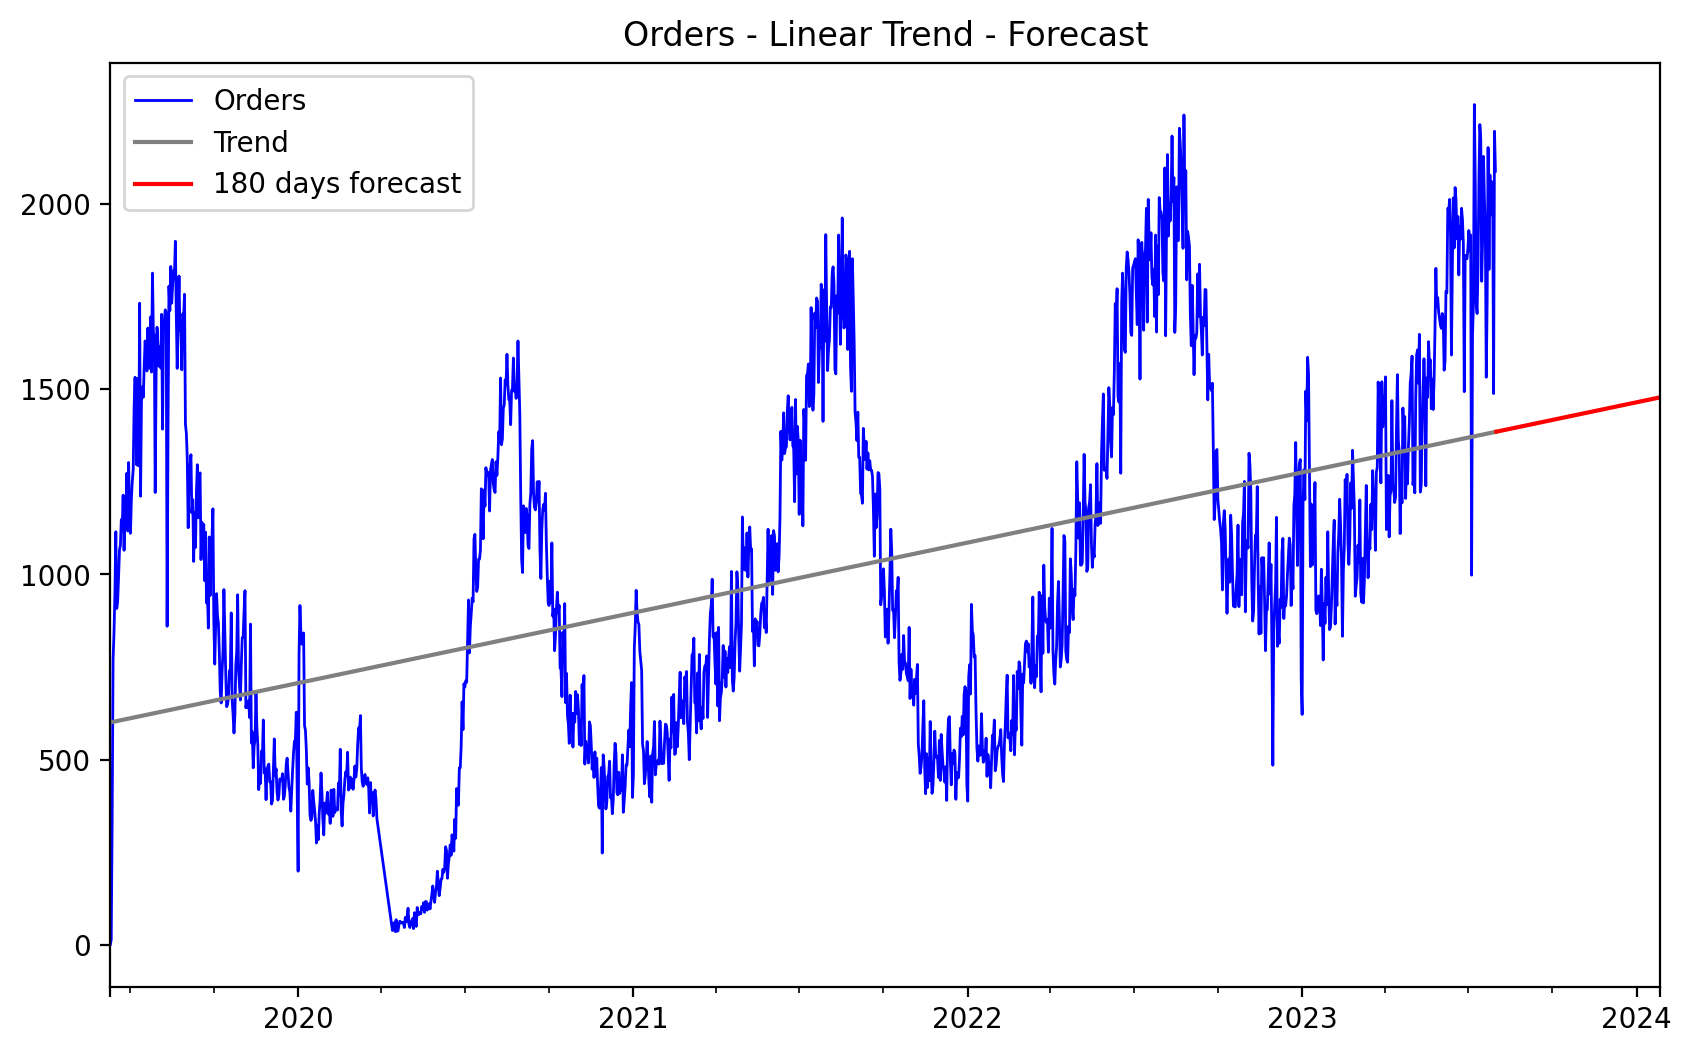

In [213]:
ax = df.plot(y="Orders", figsize=(10, 6), linewidth=1, color="blue", title="Orders - Linear Trend - Forecast")
y_pred.plot(y="Orders", ax=ax, label='Trend', color="gray")
y_fore.plot(y="Orders", ax=ax, label='180 days forecast', color="red")
ax.legend()
plt.show()

### Seasonality